## Monte Carlo Control
Evaluate Policy and improve it greedily.

On Policy model-free optimization of the value function

In [1]:
import gym
import matplotlib
import numpy as np
import sys
from collections import defaultdict
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')
env = BlackjackEnv()

In [4]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A  #np array of probabilities for each action
    
    return policy_fn

In [8]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(1, num_episodes + 1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        episode = []
        state = env.reset()
        
        for t in range(100):
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
            
        #All (state, action) pairs we have visited in this episode
        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            #find first occurence of (s, a) pait in the episode
            first_occurence_idx = next(i for i, x in enumerate(episode) if x[0] == state and x[1] == action)
            #Sum up all rewards from this first occurence
            G = sum([x[2]*(discount_factor**i) for i, x in enumerate(episode[first_occurence_idx:])])
            
            #average return for this state over all sampled episodes
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            #The policy is improved by changing this Q
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]
            
            
        return Q, policy

In [9]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)


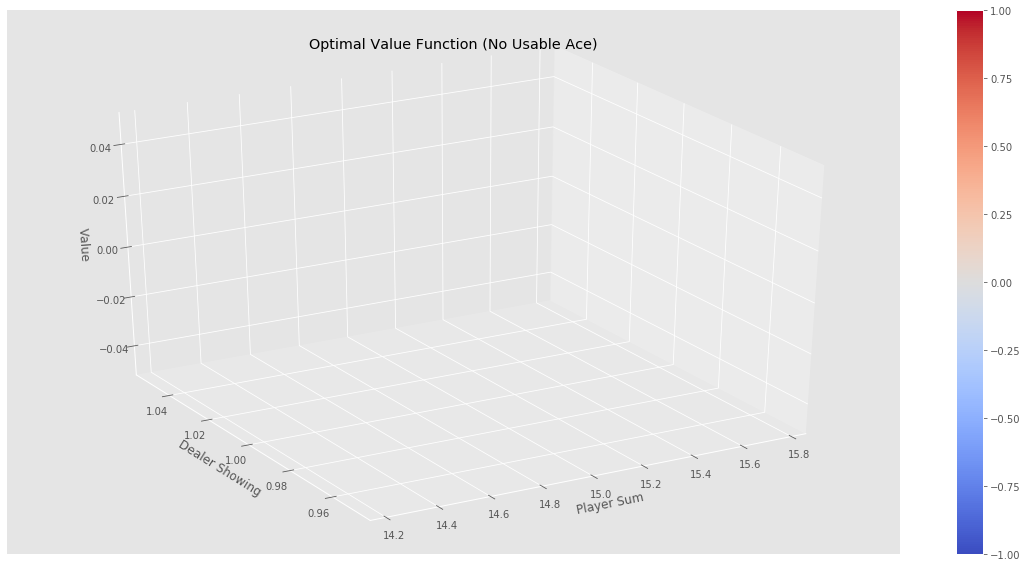

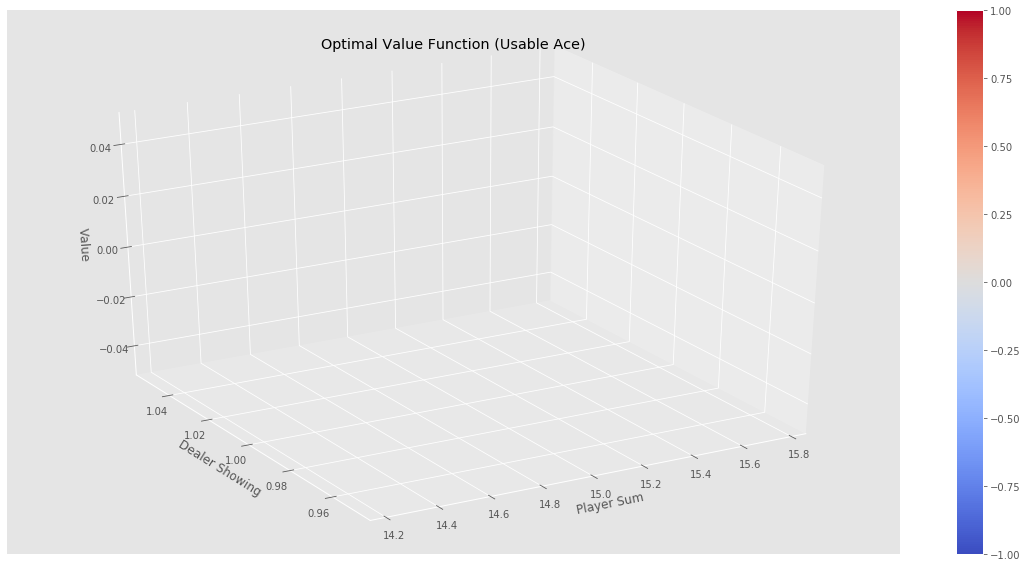

In [10]:
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value  #creating value function from action value function by selecting best action
plotting.plot_value_function(V, title="Optimal Value Function")